# Bases de Datos No Relacionales

## Proyecto Final - López & Ríos

In [78]:

#Comenzamos por importar las bibliotecas necesarias 

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

#permite conectarse a la BD 
#Fuente: https://py2neo.org/2021.1/
import py2neo
from py2neo import Graph,Node,Relationship

#permite representar gráficamente los grafos obtenidos 
#Fuente: https://github.com/merqurio/neo4jupyter
import neo4jupyter
neo4jupyter.init_notebook_mode()


print ('py2neo version', py2neo.__version__)


<IPython.core.display.Javascript object>

py2neo version 2021.2.3


In [79]:
#estos son los parámetros para la conexión a una instancia de Neo4j que se ejecuta localmente 
#y en el puerto por defecto
#si van a utilizar otra opción deben ajustar los parámetros


#indica la url de la BD
#dburl='http://localhost:7474'
dburl='bolt://127.0.0.1:7687'
user='neo4j'
pasw='bdnr'

graph = Graph(dburl, auth=(user, pasw))

In [3]:
def evaluate_query(query, n=3):
    
    # Ejecuta n consultas y mide el tiempo de cada una
    exec_times = np.zeros(n)
    run_result = None
    for i in range(n):
        st = time.time()
        run_result = graph.run(query)
        
        # get the execution time for this round
        exec_times[i] = time.time() - st
    
    mean_time = exec_times.mean()
    std_error = exec_times.std()
    
    print(f"Execution times: {list(exec_times)}")
    print(f'Execution time per round: {mean_time:.4f}±{std_error:.4f}s ({100*std_error/mean_time:.2f}%)')
    
    return run_result.to_data_frame(), exec_times

In [50]:
def plot_exec_times(times_list, labels_list):
    fig = plt.figure(figsize=(10, 6))
    for k, exec_times in enumerate(times_list):
        x = list(range(1, len(exec_times)+1))
        plt.plot(x, exec_times,label=labels_list[k], linewidth=1.0)
    plt.xlabel("# run")
    plt.ylabel("Execution time (s)")
    plt.legend()

In [35]:
# Evaluate query time without index
graph.run("DROP INDEX meas_hour IF EXISTS")
graph.run("DROP INDEX meas_date IF EXISTS")

# Búsqueda por nodos
print("Búsqueda por nodos, sin índices...")
query_date_time_nodes = """MATCH (s:Station)-->(m:Measurement)
                           WHERE m.hour = time("2:00") AND m.date = date("2019-01-01")
                           RETURN s, m"""
res_1, times_1 = evaluate_query(query_date_time_nodes, n=5)


# Búsqueda por edges
print("\n\nBúsqueda por vértices, sin índices...")
query_date_time_edges = """MATCH (s:Station)
                        -[:MEASURED{hour: time("2:00"), date:date("2019-01-01")}]
                        ->(m:Measurement)
                        RETURN m,s"""
res_2, times_2 = evaluate_query(query_date_time_edges, n=5)

assert len(res_1) == len(res_2)
res_1

Búsqueda por nodos, sin índices...
Execution times: [26.621201038360596, 27.789082288742065, 26.74163269996643, 27.568854093551636, 27.09640860557556]
Execution time per round: 27.1634±0.4544s (1.67%)


Búsqueda por vértices, sin índices...
Execution times: [26.805971384048462, 18.34953761100769, 18.979355096817017, 19.16641592979431, 19.098763942718506]
Execution time per round: 20.4800±3.1762s (15.51%)


,s,m
0,"{'latitude': -20.44444, 'name': 'MS/A756/AGUA ...","{'station_name': 'MS/A756/AGUA CLARA', 'date':..."
1,"{'latitude': -15.902658, 'name': 'GO/A013/ARAG...","{'station_name': 'GO/A013/ARAGARCAS', 'date': ..."
2,"{'latitude': -13.41111111, 'name': 'MT/A929/NO...","{'station_name': 'MT/A929/NOVA UBIRATA', 'date..."
3,"{'latitude': -14.13305554, 'station': 'ALTO PA...","{'date': 2019-01-01, 'station_name': 'GO/A024/..."
4,"{'latitude': -19.69527777, 'name': 'MS/A710/PA...","{'station_name': 'MS/A710/PARANAIBA', 'date': ..."
...,...,...
107,"{'latitude': -22.57527777, 'name': 'MS/S711/LA...","{'station_name': 'MS/S711/LAGUNA CARAPA', 'dat..."
108,"{'latitude': -18.802187, 'name': 'MS/A730/CHAP...","{'station_name': 'MS/A730/CHAPADAO DO SUL', 'd..."
109,"{'latitude': -17.785303, 'name': 'GO/A025/RIO ...","{'station_name': 'GO/A025/RIO VERDE', 'date': ..."
110,"{'latitude': -22.09277777, 'name': 'MS/S710/IT...","{'station_name': 'MS/S710/ITAPORA', 'date': 20..."


## Crear subgrafo temporal

In [6]:
def delete_nodes_transactions(node_match="Year{name:2000}"):
    query = f"""MATCH (p:{node_match})
                CALL {{
                  WITH p
                  DETACH DELETE p
                }}
                IN TRANSACTIONS OF 10000 ROWS
                RETURN COUNT(p)
                """
    # print(query)
    res = graph.run(query)
    res = 0 if res is None else next(res)[0]
    print(f"Deleted nodes matching :{node_match} : {res}")


In [7]:
%%time
# Create years in range of data
delete_nodes_transactions(node_match="Year")
graph.run("""MATCH (m:Measurement)
             WITH MIN(m.date.year) AS min_year, MAX(m.date.year) AS max_year
             FOREACH(y in range(min_year, max_year)
             | CREATE (:Year{name: y}))""")

# Create months
delete_nodes_transactions(node_match="Month")
graph.run("""FOREACH(m in range(1, 12)
             | CREATE (:Month{name: m}))""")

# Create days
delete_nodes_transactions(node_match="Day")
graph.run("""FOREACH(d in range(1, 31)
             | CREATE (:Day{name: d}))""")

# Create hours
delete_nodes_transactions(node_match="Hour")
graph.run("""FOREACH(h in range(1, 23)
             | CREATE (:Hour{name: h}))""")

DatabaseError: [Transaction.TransactionCommitFailed] The transaction cannot be committed when it has open inner transactions.

In [8]:
%%time
graph.run("""MATCH (meas:Measurement)
             MATCH (y:Year{name: meas.date.year})
             MATCH (m:Month{name: meas.date.month})
             MATCH (d:Day{name: meas.date.day})
             MATCH (h:Hour{name: meas.hour.hour})
             CALL{
                 WITH meas, y, m, d, h
                 MERGE (y)-[:Y_CONTAINS]->(meas)
                 MERGE (m)-[:M_CONTAINS]->(meas)
                 MERGE (d)-[:D_CONTAINS]->(meas)
                 MERGE (h)-[:H_CONTAINS]->(meas)
             } IN TRANSACTIONS OF 10000 ROWS""")

CPU times: total: 0 ns
Wall time: 9min 55s


(No data)

In [6]:
%%time
# See number of edges we added for this (surprisingly fast)
graph.run("MATCH ()-[:Y_CONTAINS|:M_CONTAINS|:D_CONTAINS|:H_CONTAINS]->() RETURN count(*)")

CPU times: total: 15.6 ms
Wall time: 21.9 ms


count(*)
43803960


## Búsqueda usando subgrafo temporal (sin índices)

In [37]:
# Try matching without index
query_date_time_subgraph = """MATCH (m:Measurement)<--(:Year{name:2019}),
                                 (m)<--(:Month{name:1}),
                                 (m)<--(:Day{name:1}),
                                 (m)<--(:Hour{name:2})
                           RETURN m"""
res_3, times_3 = evaluate_query(query_date_time_subgraph, n=5)
res_3

Execution times: [5.326352596282959, 3.1334645748138428, 3.0220797061920166, 3.1113924980163574, 2.990163564682007]
Execution time per round: 3.5167±0.9064s (25.77%)


,m
0,"{'station_name': 'MT/A934/ALTO TAQUARI', 'date..."
1,"{'station_name': 'MS/S710/ITAPORA', 'date': 20..."
2,"{'station_name': 'GO/A025/RIO VERDE', 'date': ..."
3,"{'station_name': 'MS/S711/LAGUNA CARAPA', 'dat..."
4,"{'station_name': 'MS/A730/CHAPADAO DO SUL', 'd..."
...,...
107,"{'station_name': 'MT/A904/SORRISO', 'date': 20..."
108,"{'date': 2019-01-01, 'station_name': 'GO/A024/..."
109,"{'station_name': 'MT/A929/NOVA UBIRATA', 'date..."
110,"{'station_name': 'GO/A013/ARAGARCAS', 'date': ..."


In [17]:
# Make sure there are no mysterious indices created before proceeding
graph.run("DROP INDEX index_343aff4e IF EXISTS")
graph.run("DROP INDEX index_f7700477 IF EXISTS")

graph.run("SHOW INDEXES").to_data_frame()

,id,name,state,populationPercent,uniqueness,type,entityType,labelsOrTypes,properties,indexProvider
0,5,UniqueMeasurementStationTime,ONLINE,100.0,UNIQUE,BTREE,NODE,[Measurement],"[station_name, name]",native-btree-1.0
1,3,UniqueStationName,ONLINE,100.0,UNIQUE,BTREE,NODE,[Station],[name],native-btree-1.0


## Subgrafo temporal con un nodo para cada día del año (no funciona)

In [13]:
# Temporal graph but hierarchical

#Create years in range of data
graph.run("""MATCH (d:DateTime) DETACH DELETE d RETURN count(d)""")

graph.run("""MATCH (meas:Measurement)
             WITH MIN(meas.date.year) AS min_year, MAX(meas.date.year) AS max_year
             FOREACH(y in range(min_year, max_year)
             | FOREACH(m in range(1, 12)
               | FOREACH(d in range(1, 31)
                 | FOREACH(h in range(0, 23) |
                   CREATE (dt:DateTime{year: y, month: m, day: d, hour: h})))))""")

(No data)

In [9]:
graph.run("MATCH (d:DateTime) RETURN COUNT(d)")

COUNT(d)
196416


In [15]:
%%time
graph.run("""MATCH (date_time:DateTime)
             MATCH (y:Year{name: date_time.year})
             MATCH (m:Month{name: date_time.month})
             MATCH (d:Day{name: date_time.day})
             MATCH (h:Hour{name: date_time.hour})
             CALL{
                 WITH date_time, y, m, d, h
                 MERGE (y)-[:YEAR_OF]->(date_time)
                 MERGE (m)-[:MONTH_OF]->(date_time)
                 MERGE (d)-[:DAY_OF]->(date_time)
                 MERGE (h)-[:HOUR_OF]->(date_time)
             } IN TRANSACTIONS OF 10000 ROWS""")

CPU times: total: 0 ns
Wall time: 14.4 s


(No data)

In [18]:
%%time
# Esta consulta sin crear las relaciones entre DateTime con Year, Month, Day, Hour, se vuelve intractable
graph.run("""MATCH (meas:Measurement)
              MATCH (d:DateTime{year: meas.date.year, month: meas.date.month, day: meas.date.day, hour: meas.hour.hour})
              CALL{
                  WITH meas, d
                  MERGE (d)-[:I_CONTAINS]->(meas)
              } IN TRANSACTIONS OF 10000 ROWS""")


# Esta consulta también es intractable:
# graph.run("""MATCH (meas:Measurement)
#              MATCH (:Year{name:meas.date.year})-[:YEAR_OF]->(dt:DateTime),
#                    (:Month{name:meas.date.month})-[:MONTH_OF]->(dt:DateTime),
#                    (:Day{name:meas.date.day})-[:DAY_OF]->(dt:DateTime),
#                    (:Hour{name:meas.hour.hour})-[:HOUR_OF]->(dt:DateTime)
#              CALL{
#                  WITH meas, dt
#                  MERGE (dt)-[:I_CONTAINS]->(meas)
#              } IN TRANSACTIONS OF 10000 ROWS""")

KeyboardInterrupt: 

In [38]:
# Estas consultas no se pueden hacer porque trazar los edges demora demasiado (consulta anterior)
query_datetime = """MATCH (m:Measurement)<--(:DateTime{year:2019, month:1, day:1, hour: 2}) RETURN m"""
res_4, times_4 = evaluate_query(query_datetime, n=5)
res_4

#query_date_subgraph = """MATCH (m:Measurement)<--(dt:DateTime)<--(:Year{name:m.date.year}),
#                                (dt:DateTime)<--(:Month{name:m.date.month}),
#                                (dt:DateTime)<--(:Day{name:m.date.day}),
#                                (dt:DateTime)<--(:Hour{name:m.hour.hour})
#                            RETURN m"""
#res_5, times_5 = evaluate_query(query_date_subgraph, n=10)
#res_5

Execution times: [0.6917073726654053, 0.6506140232086182, 0.6535942554473877, 0.7937514781951904, 0.7060916423797607]
Execution time per round: 0.6992±0.0519s (7.43%)


,m
0,"{'station_name': 'MS/A756/AGUA CLARA', 'date':..."
1,"{'station_name': 'MT/A934/ALTO TAQUARI', 'date..."
2,"{'station_name': 'MS/S710/ITAPORA', 'date': 20..."
3,"{'station_name': 'GO/A025/RIO VERDE', 'date': ..."
4,"{'station_name': 'MS/A730/CHAPADAO DO SUL', 'd..."
...,...
107,"{'station_name': 'MT/A904/SORRISO', 'date': 20..."
108,"{'station_name': 'MS/A710/PARANAIBA', 'date': ..."
109,"{'date': 2019-01-01, 'station_name': 'GO/A024/..."
110,"{'station_name': 'MT/A929/NOVA UBIRATA', 'date..."


## Comparación de búsquedas sin índices

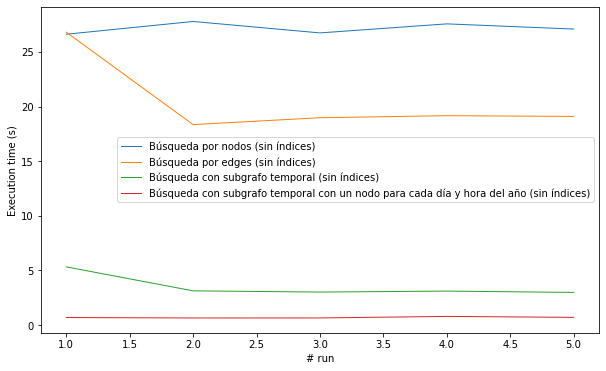

In [51]:
plot_exec_times([times_1, times_2, times_3, times_4], ["Búsqueda por nodos (sin índices)", "Búsqueda por edges (sin índices)", "Búsqueda con subgrafo temporal (sin índices)","Búsqueda con subgrafo temporal con un nodo para cada día y hora del año (sin índices)"])

## Búsqueda temporal con índices

In [80]:

# ATENCIÓN: Correr esta celda hasta que los nodos pasen de POPULATING a ONLINE
graph.run("""CREATE INDEX meas_hour IF NOT EXISTS
             FOR (m:Measurement)
             ON (m.hour)""")

graph.run("""CREATE INDEX meas_date IF NOT EXISTS
             FOR (m:Measurement)
             ON (m.date)""")

graph.run("""CREATE INDEX rel_meas IF NOT EXISTS
             FOR ()-[r:MEASURED]-()
             ON (r.date, r.hour)""")

graph.run("""CREATE INDEX date_time IF NOT EXISTS
             FOR (d:DateTime)
             ON (
                 d.hour,
                 d.day,
                 d.month,
                 d.year
                )""")

graph.run("SHOW INDEXES").to_data_frame()

,id,name,state,populationPercent,uniqueness,type,entityType,labelsOrTypes,properties,indexProvider
0,5,UniqueMeasurementStationTime,ONLINE,100.0,UNIQUE,BTREE,NODE,[Measurement],"[station_name, name]",native-btree-1.0
1,3,UniqueStationName,ONLINE,100.0,UNIQUE,BTREE,NODE,[Station],[name],native-btree-1.0
2,1,date_time,ONLINE,100.0,NONUNIQUE,BTREE,NODE,[DateTime],"[hour, day, month, year]",native-btree-1.0
3,7,meas_date,ONLINE,100.0,NONUNIQUE,BTREE,NODE,[Measurement],[date],native-btree-1.0
4,8,meas_hour,ONLINE,100.0,NONUNIQUE,BTREE,NODE,[Measurement],[hour],native-btree-1.0
5,9,rel_meas,ONLINE,100.0,NONUNIQUE,BTREE,RELATIONSHIP,[MEASURED],"[date, hour]",native-btree-1.0


In [81]:
# WARNING: Correr la celda anterior hasta que los índices pasen de POPULATING a ONLINE
query_date_time_nodes = """MATCH (s:Station)-->(m:Measurement)
                           WHERE m.hour = time("2:00") AND m.date = date("2019-01-01")
                           RETURN m"""

query_date_time_edges = """MATCH (s:Station)
                        -[:MEASURED{hour: time("2:00"), date:date("2019-01-01")}]
                        ->(m:Measurement)
                        RETURN m"""

query_date_time_subgraph = """MATCH (m:Measurement)<--(:Year{name:2019}),
                                 (m)<--(:Month{name:1}),
                                 (m)<--(:Day{name:1}),
                                 (m)<--(:Hour{name:2})
                           RETURN m"""

query_date_time_subgraph_date_time = """MATCH (m:Measurement)<--(:DateTime{year:2019, month:1, day:1, hour: 2}) RETURN m"""

print("Búsqueda por nodos, con índices...")
res_1, times_1 = evaluate_query(query_date_time_nodes, n=5)


print("\n\nBúsqueda por vértices, con índices (en los nodos)...")
res_2, times_2 = evaluate_query(query_date_time_edges, n=5)


print("\n\nBúsqueda con subgrafo temporal, con índices")
res_3, times_3 = evaluate_query(query_date_time_subgraph, n=5)

print("\n\nBúsqueda con subgrafo temporal con un nodo para cada día y hora del año, con índices")
res_4, times_4 = evaluate_query(query_date_time_subgraph_date_time, n=5)

assert len(res_2) == len(res_3)

Búsqueda por nodos, con índices...
Execution times: [0.16565155982971191, 0.03164839744567871, 0.05047488212585449, 0.037896156311035156, 0.039279937744140625]
Execution time per round: 0.0650±0.0507s (78.00%)


Búsqueda por vértices, con índices (en los nodos)...
Execution times: [0.1535022258758545, 0.03245902061462402, 0.030605792999267578, 0.037633657455444336, 0.02393364906311035]
Execution time per round: 0.0556±0.0491s (88.33%)


Búsqueda con subgrafo temporal, con índices
Execution times: [8.920443296432495, 2.818814754486084, 2.3854105472564697, 2.576427936553955, 2.3772075176239014]
Execution time per round: 3.8157±2.5575s (67.03%)


Búsqueda con subgrafo temporal con un nodo para cada día y hora del año, con índices
Execution times: [0.08583974838256836, 0.016954421997070312, 0.015958070755004883, 0.017951011657714844, 0.018949270248413086]
Execution time per round: 0.0311±0.0274s (87.93%)


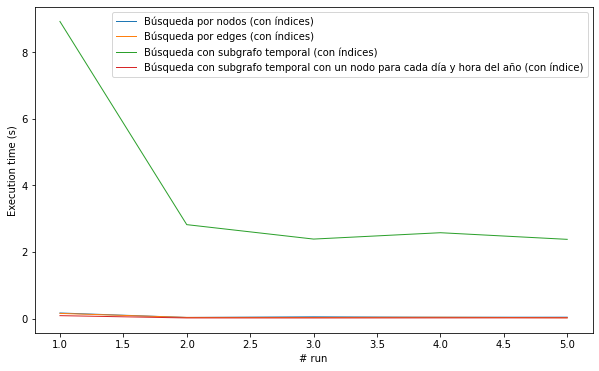

In [82]:
plot_exec_times([times_1, times_2, times_3, times_4], ["Búsqueda por nodos (con índices)", "Búsqueda por edges (con índices)", "Búsqueda con subgrafo temporal (con índices)","Búsqueda con subgrafo temporal con un nodo para cada día y hora del año (con índice)"])

In [24]:
%%time
# Vuelvo a correr esto a ver si se vuelven a crear los índices automáticos index_...
graph.run("""MATCH (meas:Measurement)
             MATCH (y:Year{name: meas.date.year})
             MATCH (m:Month{name: meas.date.month})
             MATCH (d:Day{name: meas.date.day})
             MATCH (h:Hour{name: meas.hour.hour})
             CALL{
                 WITH meas, y, m, d, h
                 MERGE (y)-[:Y_CONTAINS]->(meas)
                 MERGE (m)-[:M_CONTAINS]->(meas)
                 MERGE (d)-[:D_CONTAINS]->(meas)
                 MERGE (h)-[:H_CONTAINS]->(meas)
             } IN TRANSACTIONS OF 10000 ROWS""")

CPU times: user 6.92 ms, sys: 4.84 ms, total: 11.8 ms
Wall time: 3min 8s


(No data)

In [57]:
graph.run("SHOW INDEXES").to_data_frame()

,id,name,state,populationPercent,uniqueness,type,entityType,labelsOrTypes,properties,indexProvider
0,5,UniqueMeasurementStationTime,ONLINE,100.0,UNIQUE,BTREE,NODE,[Measurement],"[station_name, name]",native-btree-1.0
1,3,UniqueStationName,ONLINE,100.0,UNIQUE,BTREE,NODE,[Station],[name],native-btree-1.0
2,7,meas_date,ONLINE,100.0,NONUNIQUE,BTREE,NODE,[Measurement],[date],native-btree-1.0
3,8,meas_hour,ONLINE,100.0,NONUNIQUE,BTREE,NODE,[Measurement],[hour],native-btree-1.0
4,9,rel_meas,ONLINE,100.0,NONUNIQUE,BTREE,RELATIONSHIP,[MEASURED],"[date, hour]",native-btree-1.0




Búsqueda con subgrafo temporal, con índices
Execution times: [1.7273948192596436, 1.5610051155090332, 1.2974231243133545, 1.2672882080078125, 1.2637171745300293, 1.2400312423706055, 1.2375450134277344, 1.235694169998169, 1.2338547706604004, 1.2297511100769043]
Execution time per round: 1.3294±0.1629s (12.26%)


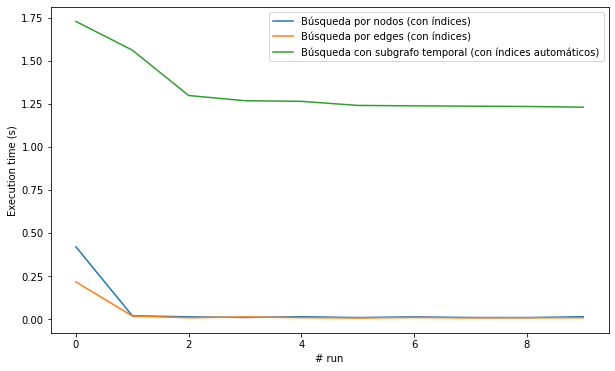

In [26]:
# Vuelvo a correr la consulta 3 a ver si mejora
print("\n\nBúsqueda con subgrafo temporal, con índices")
res_3_re, times_3_re = evaluate_query(query_date_time_subgraph, n=10)
plot_exec_times([times_1, times_2, times_3_re], ["Búsqueda por nodos (con índices)", "Búsqueda por edges (con índices)", "Búsqueda con subgrafo temporal (con índices automáticos)"])

### Comentarios sobre las celdas anteriores

Luego de crear los índices, deja de tener sentido correr la consulta con subgrafo temporal, ya que enlentece.

Había algunos índices que se crean sólos, llamados "index_...", con los que la consulta con el subgrafo temporal andaba mucho más rápido. No sé como recrearlos, el intento de las últimas celdas no funcionó.

Otra cosa a mencionar es que cuando las consultas se vuelven untractable, no hay forma de cortar la ejecución sin matar los procesos de java, que generan inconsistencias de datos. Darle stop al servidor demora muchísimo, e incluso después deja un proceso huérfano de java que nunca termina y consume significativa CPU (como si continuara ejecutando la consulta).

In [75]:
# Tres consultas interesantes a comparar:

# Esta demora ~70 segundos
_ = evaluate_query(
"""
MATCH (s0:Station{name: "MS/A756/AGUA CLARA"})-->(m0:Measurement)
MATCH (s:Station)-->(m:Measurement{hour: m0.hour, date: m0.date})
WITH s0, s, m0, m, point.distance(point({longitude: s.longitude, latitude: s.latitude}), point({longitude: s0.longitude, latitude: s0.latitude}))/1000 AS travelDistance
WHERE travelDistance < 300 AND m0.date = date("2019-01-01") AND m0.hour.hour = 2
RETURN s0, s
"""
, n=5)

# Notar que la distancia se calcula entre estaciones y no entre Measurements. Sin embargo, el hecho de
# que el filtrado por distancia se hace sobre los pares (:Station)->(:Measurement)
# (en vez de sólamente nodos de (:Station)),
# parece hacer que la distancia se ejecute en cada par, resultando en una consulta muy lenta.


# Entonces probamos otra opción: primero filtrar las estaciones por distancia, y luego hacer el matching con (:Measurements)
# Ahora la consulta demora ~5 segundos
_ = evaluate_query(
"""
MATCH (s0:Station{name: "MS/A756/AGUA CLARA"})
MATCH (s:Station)
WITH s0, s, point.distance(point({longitude: s.longitude, latitude: s.latitude}), point({longitude: s0.longitude, latitude: s0.latitude}))/1000 AS travelDistance
WHERE travelDistance < 300
MATCH (s0)-->(m0:Measurement)
MATCH (s)-->(m:Measurement{date:m0.date, hour: m0.hour})
WHERE m0.date = date("2019-01-01") AND m0.hour.hour = 2
RETURN s0, s
"""
, n=5)

# Sin embargo, aún se tiene que ejecutar la distancia entre todas las ~600 nodos
#  (:Station), y no sólo contra las que tienen (:Measurements) para ese día y hora


# Probamos entonces primero filtrar los Measurements, y luego las estaciones por distancia
# Volvemos a una consulta idéntica a la primera, sólo cambiando el orden de los WITH/WHERE
_ = evaluate_query(
"""
MATCH (s0:Station{name: "MS/A756/AGUA CLARA"})-->(m0:Measurement)
MATCH (s:Station)-->(m:Measurement{hour: m0.hour, date: m0.date})
WHERE m0.date = date("2019-01-01") AND m0.hour.hour = 2
WITH s0, s, m0, m, point.distance(point({longitude: s.longitude, latitude: s.latitude}), point({longitude: s0.longitude, latitude: s0.latitude}))/1000 AS travelDistance
WHERE travelDistance < 300
RETURN s0, s
"""
, n=5)
# Esta consulta, demora menos de 50ms :party:


# Por lo tanto, aunque a priori parezca un poco anti-intuitivo aplicar el WHERE primero sobre los measurements
# (que son muchos más registros que las estaciones), ejecutar una función de distancia es relativamente costoso
# y por lo tanto es conveniente hacer ese filtrado al final, sobre la menor cantidad de registros posibles

Execution times: [133.95534944534302, 136.25075435638428, 133.73389053344727, 131.51721358299255, 129.58871293067932]
Execution time per round: 133.0092±2.2739s (1.71%)
Execution times: [7.109611511230469, 6.903726577758789, 6.466206312179565, 6.9376959800720215, 7.070847988128662]
Execution time per round: 6.8976±0.2292s (3.32%)
Execution times: [0.01558542251586914, 0.015621662139892578, 0.01562047004699707, 0.01602029800415039, 0.03125429153442383]
Execution time per round: 0.0188±0.0062s (33.04%)


In [ ]:
#Creamos los EDGES de distancia entre todas las estaciones
graph.run("""MATCH (s0:Station),(s:Station)
             WHERE s0 <> s
             WITH s0, s, point.distance(point({longitude: s.longitude, latitude: s.latitude}), point({longitude: s0.longitude, latitude: s0.latitude}))/1000 AS Distance
             CALL{
                WITH s0, s, Distance
                MERGE (s0)-[:S_DISTANCE{distance:Distance}]-(s)
             } IN TRANSACTIONS OF 10000 ROWS""")

In [77]:
# Con EDGES de S_DISTANCE:
_ = evaluate_query(
"""
MATCH (m0:Measurement)<--(s0:Station{name: "MS/A756/AGUA CLARA"})-[d:S_DISTANCE]-(s:Station)-->(m:Measurement{hour: m0.hour, date: m0.date})
WHERE m0.date = date("2019-01-01") AND m0.hour.hour = 2 and d.distance < 300
RETURN s0, s
"""
, n=5)

Execution times: [0.014960289001464844, 0.013998270034790039, 0.0169527530670166, 0.011967658996582031, 0.017918109893798828]
Execution time per round: 0.0152±0.0021s (13.96%)


In [47]:
station_name = "MS/A756/AGUA CLARA"


dfs = {}
for distance in [100, 500, 1000]:
    dfs[distance] = graph.run(f"""
        MATCH (s0:Station{{name: "{station_name}"}})-->(m0:Measurement)
        MATCH (s:Station)-->(m:Measurement{{hour: m0.hour, date: m0.date}})
        WITH s0, s, m0, m
        WHERE m0.date > date("2021-04-20") AND m.temperature <> -9999
              AND m0.hour.hour IN [13, 14, 15]
        WITH s0, s, m0, m,
        point.distance(point({{longitude: s.longitude, latitude: s.latitude}}),
                       point({{longitude: s0.longitude, latitude: s0.latitude}}))/1000 AS distance
        WHERE distance < {distance}
        RETURN m0.name,
               m0.temperature AS t0,
               AVG(m.temperature) AS t_avg,
               ABS(m0.temperature - AVG(m.temperature)) AS AbsoluteError
        ORDER BY m0.name
        """).to_data_frame()

dfs[100]

,m0.name,t0,t_avg,AbsoluteError
0,2021-04-21T13:00,17.0,16.300000,0.700000
1,2021-04-21T14:00,16.2,15.900000,0.300000
2,2021-04-21T15:00,15.5,15.500000,0.000000
3,2021-04-22T13:00,16.5,15.866667,0.633333
4,2021-04-22T14:00,16.3,15.833333,0.466667
5,2021-04-22T15:00,14.0,14.400000,0.400000
6,2021-04-23T13:00,16.0,15.200000,0.800000
7,2021-04-23T14:00,15.9,15.166667,0.733333
8,2021-04-23T15:00,15.2,14.966667,0.233333
9,2021-04-24T13:00,15.9,14.933333,0.966667


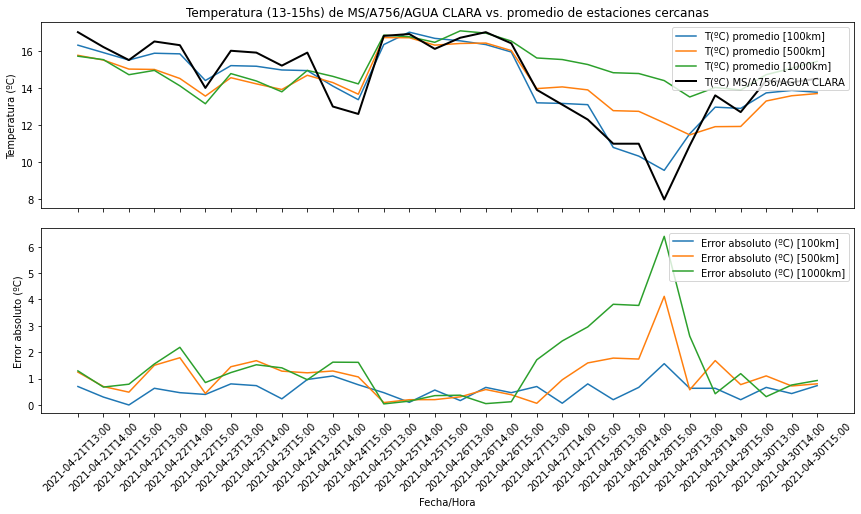

In [49]:
datetimes = dfs[100]["m0.name"]


fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 6), sharex=True)
fig.tight_layout(pad=1.0)

axes[0].set_title(f"Temperatura (13-15hs) de {station_name} vs. promedio de estaciones cercanas")
axes[0].set_ylabel("Temperatura (ºC)")
axes[1].set_ylabel("Error absoluto (ºC)")
axes[1].set_xlabel("Fecha/Hora")

for distance in dfs:
    axes[0].plot(datetimes, dfs[distance]["t_avg"], label=f"T(ºC) promedio [{distance}km]")
    axes[1].plot(datetimes, dfs[distance]["AbsoluteError"], label=f"Error absoluto (ºC) [{distance}km]")

axes[0].plot(datetimes, dfs[100]["t0"], "-k", label=f"T(ºC) {station_name}", linewidth=2)

axes[0].legend(loc="upper right")
axes[1].legend(loc="upper right")
# axes[0].set_xticklabels(ticks=axes[0].get_xticks(), labels=axes[0].get_xlabels(), rotation=90)
# _ = axes[1].set_xticklabels(ticks=axes[1].get_xticks(), labels=axes[1].get_xlabels(), rotation=90)
axes[0].tick_params(axis="x", labelrotation=45)
axes[1].tick_params(axis="x", labelrotation=45)

In [149]:
station_name = "MS/A756/AGUA CLARA"
search_distance = 500
search_date = "2021-04-30"
search_time = "14:00"

ref_station = graph.run(f"""
    MATCH (s:Station{{name: "{station_name}"}})
    RETURN s.name, s.latitude, s.longitude
    """).to_data_frame().iloc[0]

df_map = graph.run(f"""
    MATCH (s0:Station{{name: "{station_name}"}})
           -->(m0:Measurement{{date: date("{search_date}"), hour: time("{search_time}")}})
    MATCH (s:Station)-->(m:Measurement{{hour: m0.hour, date: m0.date}})
    WHERE m.temperature <> -9999
    WITH s0, m0, s, m,
         point.distance(point({{longitude: s.longitude, latitude: s.latitude}}),
                        point({{longitude: s0.longitude, latitude: s0.latitude}}))/1000
                        AS distance
    WHERE distance < {search_distance}
    RETURN s.name, s.latitude, s.longitude
    """).to_data_frame()
df_map

,s.name,s.latitude,s.longitude
0,MT/A907/RONDONOPOLIS,-16.450000,-54.566667
1,GO/A027/PARAUNA,-16.945833,-50.425278
2,MS/S710/ITAPORA,-22.092778,-54.798833
3,GO/A011/SAO SIMAO,-18.966667,-50.616667
4,GO/A035/ITUMBIARA,-18.409722,-49.191944
5,GO/A023/CAIAPONIA,-16.966667,-51.817500
6,GO/A028/IPORA,-16.423056,-51.148056
7,MS/A760/COSTA RICA,-18.492665,-53.171261
8,MS/S715/RIBAS DO RIO PARDO,-20.466667,-53.763028
9,MS/S701/ANGELICA,-22.148056,-53.763611


In [150]:
df_map["error"] = 0
avg_distance = 500

for station in [station_name] + list(df_map["s.name"]):
    station_query = graph.run(f"""
        MATCH (s0:Station{{name: "{station}"}})
               -->(m0:Measurement{{date: date("{search_date}"), hour: time("{search_time}")}})
        MATCH (s:Station)-->(m:Measurement{{hour: m0.hour, date: m0.date}})
        WHERE m.temperature <> -9999 AND s <> s0
        WITH s0, m0, s, m, point.distance(point({{longitude: s.longitude, latitude: s.latitude}}), point({{longitude: s0.longitude, latitude: s0.latitude}}))/1000 AS distance
        WHERE distance < {avg_distance}

        RETURN AVG(m.temperature) as avg_temperature, ABS(m0.temperature - AVG(m.temperature)) AS AbsoluteError
        """).to_data_frame().iloc[0]
    df_map.loc[df_map["s.name"] == station, "error"] = station_query["AbsoluteError"]
df_map

,s.name,s.latitude,s.longitude,error
0,MT/A907/RONDONOPOLIS,-16.450000,-54.566667,2.460000
1,GO/A027/PARAUNA,-16.945833,-50.425278,0.014286
2,MS/S710/ITAPORA,-22.092778,-54.798833,0.047619
3,GO/A011/SAO SIMAO,-18.966667,-50.616667,2.708333
4,GO/A035/ITUMBIARA,-18.409722,-49.191944,1.431034
5,GO/A023/CAIAPONIA,-16.966667,-51.817500,1.884615
6,GO/A028/IPORA,-16.423056,-51.148056,1.077778
7,MS/A760/COSTA RICA,-18.492665,-53.171261,3.997059
8,MS/S715/RIBAS DO RIO PARDO,-20.466667,-53.763028,0.196552
9,MS/S701/ANGELICA,-22.148056,-53.763611,0.177273


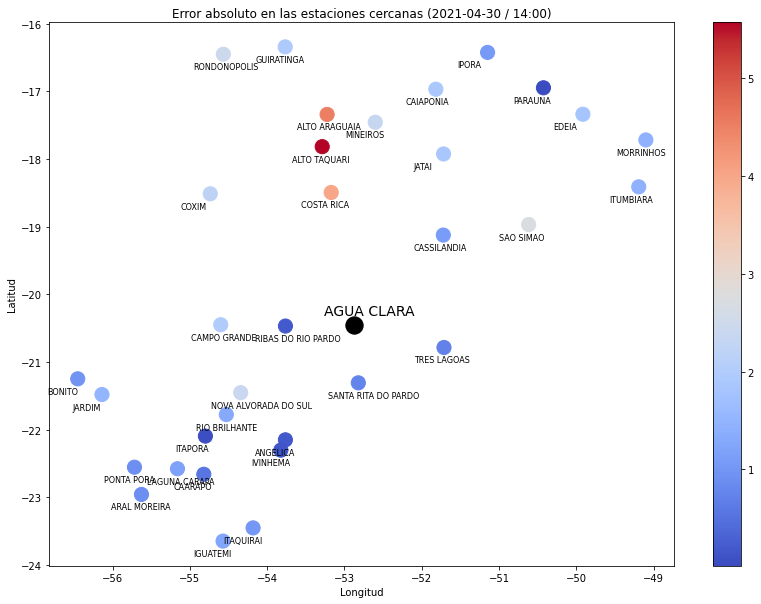

In [151]:

fig, ax = plt.subplots(figsize=(14, 10))

ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")
ax.set_title(f"Error absoluto en las estaciones cercanas ({search_date} / {search_time})")
ax.annotate(station_name.split("/")[-1], (ref_station["s.longitude"], ref_station["s.latitude"]),
           textcoords="offset pixels", xytext=(-30, 10), size=14)

m = ax.scatter(df_map["s.longitude"], df_map["s.latitude"], c=df_map["error"], cmap="coolwarm", marker="o", s=200)
fig.colorbar(m, ax=ax)

ax.scatter([ref_station["s.longitude"]], [ref_station["s.latitude"]], c="k", s=300, edgecolor="k")

for idx in df_map.index:
    name = df_map.loc[idx, "s.name"]
    if name == station_name:
        continue
    txt_offset = (-30, -15)
    txt_size = 8
    station_display = name.split("/")[-1]
    ax.annotate(station_display, (df_map.loc[idx, "s.longitude"], df_map.loc[idx, "s.latitude"]),
                textcoords="offset pixels", xytext=txt_offset, size=txt_size)